In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



def read_reg_lines(path:Path) -> pd.DataFrame:
    return pd.read_csv(path)

In [4]:
path1 = Path(
    r"F:\\απο  την επιφανια  εργασια\\create data\setdata\\return\\final\\tables\\country_metrics.csv"
)
country_metrics = read_reg_lines(path1)

In [6]:
# 🔹 Βοηθητική συνάρτηση Lorenz (γενική)

def lorenz_curve(values: pd.Series):
    """
    Υπολογίζει σημεία Lorenz curve.
    Επιστρέφει:
    - cumulative population share
    - cumulative value share
    """
    values = values.dropna().abs().sort_values()
    
    cum_values = values.cumsum()
    total = cum_values.iloc[-1]
    
    lorenz_y = cum_values / total
    lorenz_x = np.linspace(0, 1, len(lorenz_y))
    
    # Προσθέτουμε (0,0)
    lorenz_x = np.insert(lorenz_x, 0, 0)
    lorenz_y = np.insert(lorenz_y, 0, 0)
    
    return lorenz_x, lorenz_y


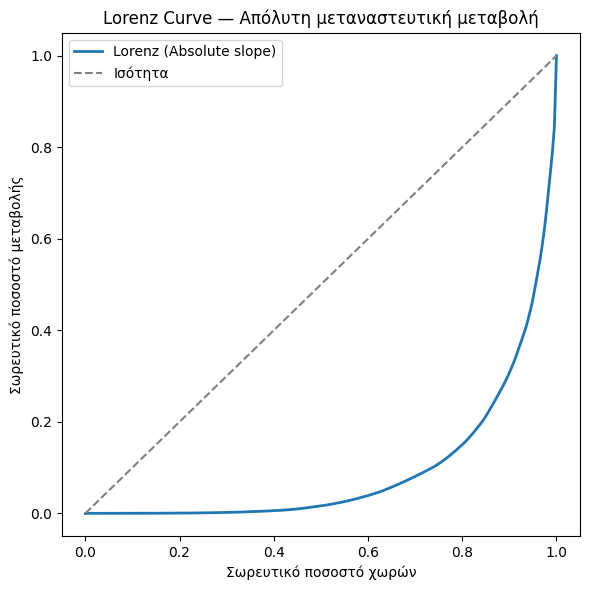

In [9]:
# 🔴 2.1 Lorenz Curve — Absolute slope

pathout_figures = Path(
    r"F:\\απο  την επιφανια  εργασια\\create data\setdata\\return\\final\\figures"
)

x_abs, y_abs = lorenz_curve(country_metrics["slope"])

plt.figure(figsize=(6,6))
plt.plot(x_abs, y_abs, label="Lorenz (Absolute slope)", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Ισότητα")

plt.title("Lorenz Curve — Απόλυτη μεταναστευτική μεταβολή")
plt.xlabel("Σωρευτικό ποσοστό χωρών")
plt.ylabel("Σωρευτικό ποσοστό μεταβολής")
plt.legend()
plt.tight_layout()

plt.savefig(pathout_figures / "lorenz_absolute.png", dpi=300)
plt.show()


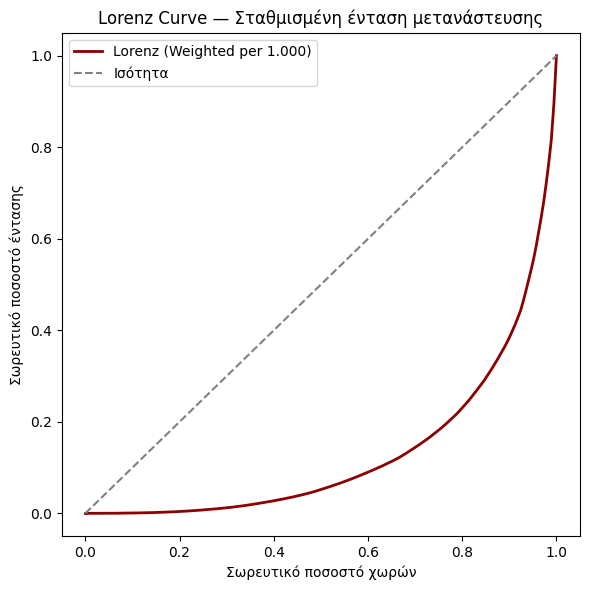

In [ ]:
# 🔴 2.2 Lorenz Curve — Weighted (ανά 1.000 κατοίκους)

x_w, y_w = lorenz_curve(country_metrics["slope_per_1000"])

plt.figure(figsize=(6,6))
plt.plot(x_w, y_w, label="Lorenz (Weighted per 1.000)", linewidth=2, color="darkred")
plt.plot([0,1], [0,1], linestyle="--", color="gray", label="Ισότητα")

plt.title("Lorenz Curve — Σταθμισμένη ένταση μετανάστευσης")
plt.xlabel("Σωρευτικό ποσοστό χωρών")
plt.ylabel("Σωρευτικό ποσοστό έντασης")
plt.legend()
plt.tight_layout()

plt.savefig(pathout_figures / "lorenz_weighted.png", dpi=300)
plt.show()


In [12]:
def gini(x):
    x = x[x >= 0]
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini_abs = gini(country_metrics["slope"].values)
gini_w   = gini(country_metrics["slope_per_1000"].values)

gini_abs, gini_w


(np.float64(0.8050681780257158), np.float64(0.7135392348050186))

In [13]:
country_metrics[["slope", "slope_per_1000"]].corr(method="spearman")


,slope,slope_per_1000
slope,1.00000,0.72487
slope_per_1000,0.72487,1.00000


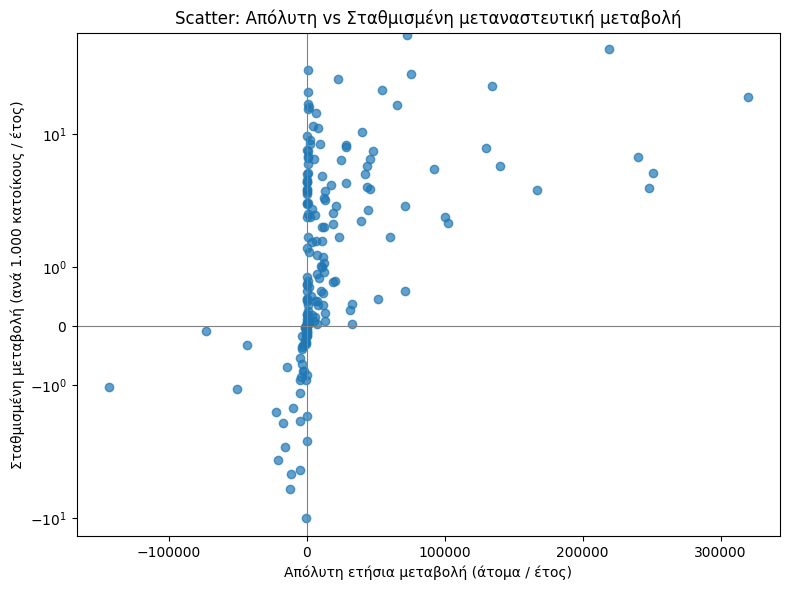

In [27]:
# Βασικό scatter (χωρίς styling ακόμα)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(
    country_metrics["slope"],
    country_metrics["slope_per_1000"],
    alpha=0.7
)

plt.axhline(0, color="grey", linewidth=0.8)
plt.axvline(0, color="grey", linewidth=0.8)

plt.xlabel("Απόλυτη ετήσια μεταβολή (άτομα / έτος)")
plt.ylabel("Σταθμισμένη μεταβολή (ανά 1.000 κατοίκους / έτος)")
plt.title("Scatter: Απόλυτη vs Σταθμισμένη μεταναστευτική μεταβολή")
plt.yscale("symlog")

plt.tight_layout()
plt.show()


In [21]:
block_colors = {
    "Top (↑)": "#1f77b4",      # μπλε
    "Neutral (≈)": "#7f7f7f",  # γκρι
    "Bottom (↓)": "#d62728"    # κόκκινο
}


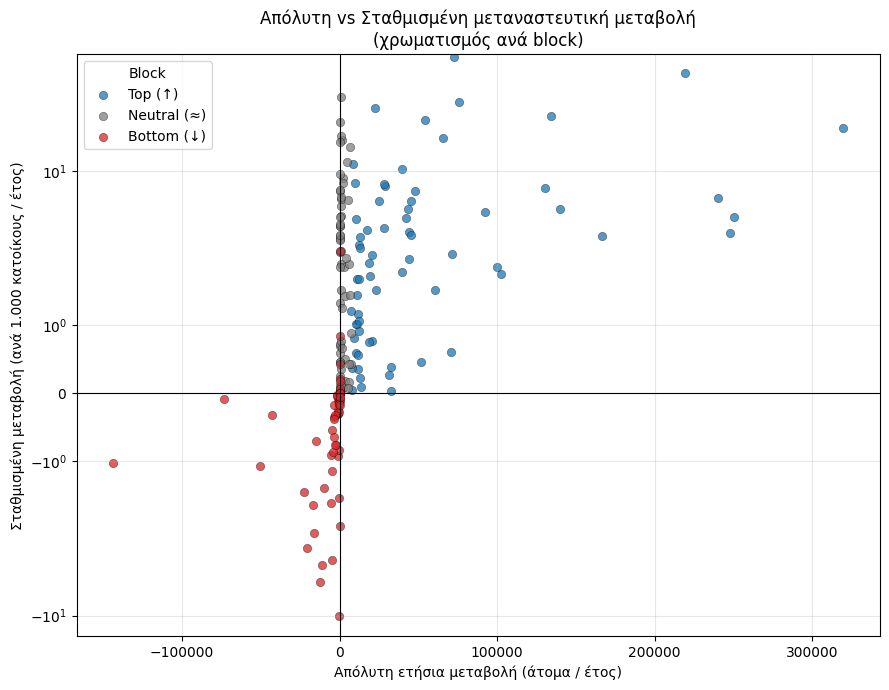

In [26]:
plt.figure(figsize=(9, 7))

for block, color in block_colors.items():
    subset = country_metrics[country_metrics["block"] == block]
    
    plt.scatter(
        subset["slope"],
        subset["slope_per_1000"],
        label=block,
        color=color,
        alpha=0.75,
        edgecolor="black",
        linewidth=0.3
    )

# Άξονες αναφοράς
plt.axhline(0, color="black", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)

plt.xlabel("Απόλυτη ετήσια μεταβολή (άτομα / έτος)")
plt.ylabel("Σταθμισμένη μεταβολή (ανά 1.000 κατοίκους / έτος)")
plt.title("Απόλυτη vs Σταθμισμένη μεταναστευτική μεταβολή\n(χρωματισμός ανά block)")
plt.yscale("symlog")

plt.legend(title="Block")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [28]:
# thresholds (95ο εκατοστημόριο)
abs_thr = country_metrics["slope"].abs().quantile(0.95)
w_thr = country_metrics["slope_per_1000"].abs().quantile(0.95)

outliers = country_metrics[
    (country_metrics["slope"].abs() >= abs_thr) |
    (country_metrics["slope_per_1000"].abs() >= w_thr)
]


In [29]:
outliers[["country", "slope", "slope_per_1000", "block"]]


,country,slope,slope_per_1000,block
11,Australia,130084.013166,7.316705,Top (↑)
15,Bahrain,22323.169804,32.624916,Top (↑)
29,British Virgin Islands,478.492679,24.950943,Neutral (≈)
37,Canada,140089.551864,4.928049,Top (↑)
38,Cayman Islands,643.640704,19.153097,Neutral (≈)
82,Germany,247737.487880,3.103048,Top (↑)
106,Italy,166667.800787,2.942743,Top (↑)
109,Jordan,134059.585456,28.042784,Top (↑)
113,Kuwait,75753.235142,36.514088,Top (↑)
157,Oman,54121.134244,25.961252,Top (↑)


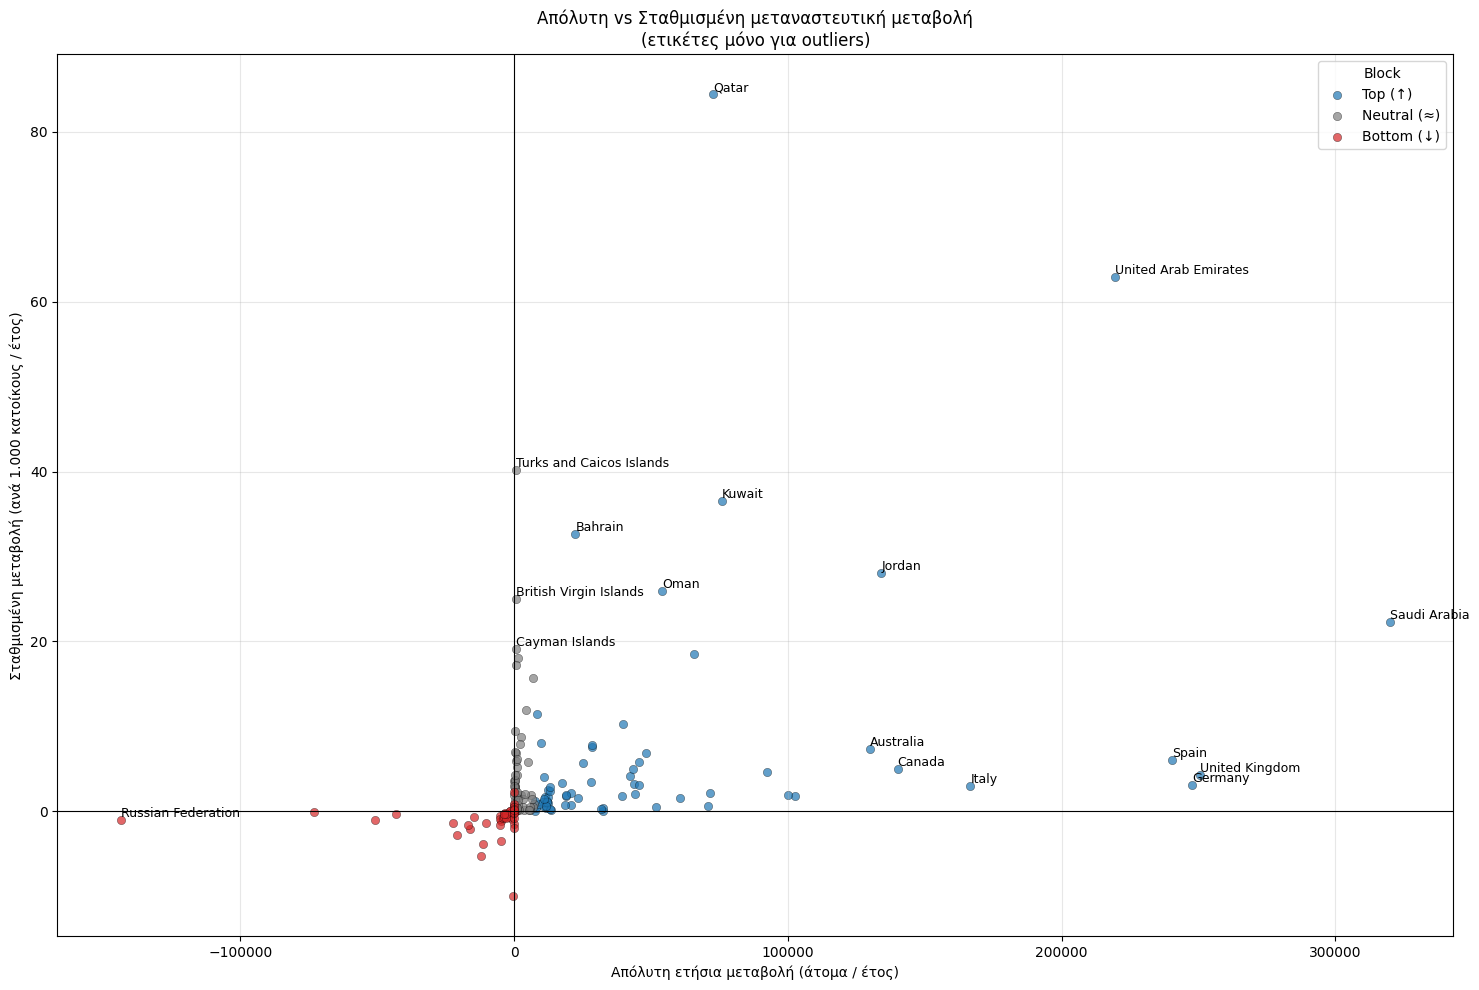

In [34]:
plt.figure(figsize=(15, 10))

# Scatter ανά block
for block, color in block_colors.items():
    subset = country_metrics[country_metrics["block"] == block]
    plt.scatter(
        subset["slope"],
        subset["slope_per_1000"],
        label=block,
        color=color,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.3
    )

# Άξονες
plt.axhline(0, color="black", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)

# --- ΕΤΙΚΕΤΕΣ ΜΟΝΟ ΓΙΑ OUTLIERS ---
for _, row in outliers.iterrows():
    plt.text(
        row["slope"],
        row["slope_per_1000"],
        row["country"],
        fontsize=9,
        ha="left",
        va="bottom"
    )

plt.xlabel("Απόλυτη ετήσια μεταβολή (άτομα / έτος)")
plt.ylabel("Σταθμισμένη μεταβολή (ανά 1.000 κατοίκους / έτος)")
plt.title("Απόλυτη vs Σταθμισμένη μεταναστευτική μεταβολή\n(ετικέτες μόνο για outliers)")
plt.legend(title="Block")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
